## Assignment: Image recognition
- Alumno 1: Victor Morcuende Castell
- Alumno 2: Guillermo Najera Lavid
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem (28th Feb - 7th Mar).
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task (7th Mar - 14th Mar).
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning (14th Mar - 23rd Mar)

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/UeDNT7JEYFkCVPP](https://drive.upm.es/s/UeDNT7JEYFkCVPP)

In [1]:
import tensorflow as tf

In [2]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [3]:
categories = {0: 'CARGO_PLANE', 1: 'HELICOPTER', 2: 'SMALL_CAR', 3: 'BUS', 4: 'TRUCK', 5: 'MOTORBOAT', 6: 'FISHING_VESSEL', 7: 'DUMP_TRUCK', 8: 'EXCAVATOR', 9: 'BUILDING', 10: 'STORAGE_TANK', 11: 'SHIPPING_CONTAINER'}

In [4]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [6]:
import json

# Load database
json_file = "C:/Users/guill/Downloads/xview_recognition/xview_recognition/xview_ann_train.json"
#json_file = "/Users/victor/Downloads/xview_recognition/xview_ann_train.json"
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [7]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'], json_data['annotations']):
    image = GenericImage("C:/Users/guill/Downloads/xview_recognition/xview_recognition/" + json_img['file_name'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.id = json_ann['id']
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = list(categories.values())[json_ann['category_id']-1]
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'CARGO_PLANE': 635, 'HELICOPTER': 70, 'SMALL_CAR': 11675, 'BUS': 4017, 'TRUCK': 5836, 'MOTORBOAT': 571, 'FISHING_VESSEL': 457, 'DUMP_TRUCK': 1108, 'EXCAVATOR': 741, 'BUILDING': 13011, 'STORAGE_TANK': 1249, 'SHIPPING_CONTAINER': 816}


In [8]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)

In [9]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1_l2

input_shape = (224, 224, 3)

base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=input_shape, pooling=max)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='gelu', kernel_regularizer=l1_l2(0.001), bias_regularizer=l1_l2(0.001))(x)
x = Dropout(0.3)(x)
predictions = Dense(len(categories), kernel_regularizer=l1_l2(0.001), bias_regularizer=l1_l2(0.001), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()


'''

# Load architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.regularizers import l1, l2
from keras.initializers import he_normal

print('Load model')
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape=(224, 224, 3), kernel_initializer="he_normal"))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Activation('gelu'))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), input_shape=(224, 224, 3), kernel_initializer="he_normal"))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Activation('gelu'))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), input_shape=(224, 224, 3), kernel_initializer="he_normal"))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Activation('gelu'))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3,3), input_shape=(224, 224, 3), kernel_initializer="he_normal"))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Activation('gelu'))
model.add(Dropout(0.3))

model.add(Conv2D(512, (3,3), input_shape=(224, 224, 3), kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001), kernel_initializer="he_normal"))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Activation('gelu'))
model.add(Dropout(0.4))

model.add(Conv2D(1024, (3,3), input_shape=(224, 224, 3), kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), kernel_initializer="he_normal"))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Activation('gelu'))
model.add(Dropout(0.5))
model.add(Flatten(input_shape=(224, 224, 3)))

model.add(Dense(1024, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Activation('gelu'))
model.add(Dropout(0.5))

model.add(Dense(512, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Activation('gelu'))
model.add(Dropout(0.5))

model.add(Dense(256, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Activation('gelu'))
model.add(Dropout(0.5))

model.add(Dense(128, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Activation('gelu'))
model.add(Dropout(0.5))

model.add(Dense(len(categories), kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
model.add(Activation('softmax'))
model.summary() '''

43950080/43941136 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________

'\n\n# Load architecture\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, LeakyReLU\nfrom tensorflow.keras.regularizers import l1, l2\nfrom keras.initializers import he_normal\n\nprint(\'Load model\')\nmodel = Sequential()\n\nmodel.add(Conv2D(32, (3,3), input_shape=(224, 224, 3), kernel_initializer="he_normal"))\nmodel.add(MaxPooling2D(2,2))\nmodel.add(BatchNormalization())\nmodel.add(Activation(\'gelu\'))\nmodel.add(Dropout(0.3))\n\nmodel.add(Conv2D(64, (3,3), input_shape=(224, 224, 3), kernel_initializer="he_normal"))\nmodel.add(MaxPooling2D(2,2))\nmodel.add(BatchNormalization())\nmodel.add(Activation(\'gelu\'))\nmodel.add(Dropout(0.3))\n\nmodel.add(Conv2D(128, (3,3), input_shape=(224, 224, 3), kernel_initializer="he_normal"))\nmodel.add(MaxPooling2D(2,2))\nmodel.add(BatchNormalization())\nmodel.add(Activation(\'gelu\'))\nmodel.add(Dropout(0.3))\n\nmodel.add(Conv2D(256, 

In [10]:
from tensorflow.keras.optimizers import Adam

# Learning rate is changed to 0.001
opt = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.00, amsgrad=True, clipnorm=1.0, clipvalue=0.5)
#opt = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.00, clipnorm=1.0, clipvalue=0.5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [11]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from datetime import datetime

batch_size = 8
epochs = 12
# Callbacks
model_checkpoint = ModelCheckpoint('model.hdf5', monitor='val_categorical_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_categorical_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_categorical_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
path = f'C:/Users/guill/Documents/GitHub/DL_1/logs/models/CNN_date_{datetime.now().strftime("%d-%m-%Y-%H-%M-%S")}_batch{batch_size}_epoch_{epochs}'
tensorboard = TensorBoard(log_dir = path, histogram_freq=1)
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [12]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
# train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
# valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)
import joblib
train_X, train_y = joblib.load("Data/prevarsTrainTotal.joblib")
valid_X, valid_y = joblib.load("Data/prevarsValidationTotal.joblib")
def generator(x, y, batch_size):
    while True:
        for i in range(0, len(x), batch_size):
            yield x[i:i+batch_size], y[i:i+batch_size]
train_generator = generator(train_X, train_y, batch_size)
valid_generator = generator(valid_X, valid_y, batch_size)

In [13]:
import math
import numpy as np
print('Training model')
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data = valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_categorical_accuracy']))
best_value = np.max(h.history['val_categorical_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_categorical_accuracy ' + str(best_value))

Training model
Epoch 1/12
1596/4521 [=========>....................] - ETA: 9:34 - loss: 2.0973 - categorical_accuracy: 0.6469

#### Testing
Try to improve the results provided in the Moodle competition wiki.

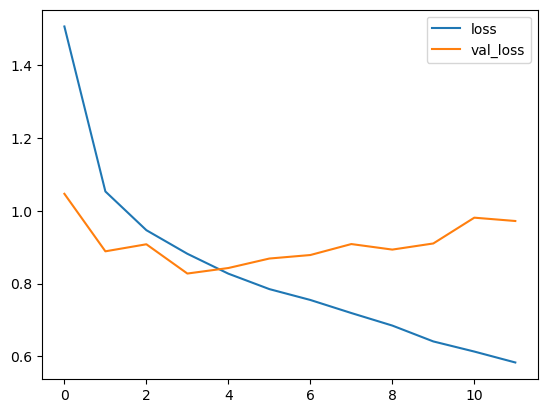

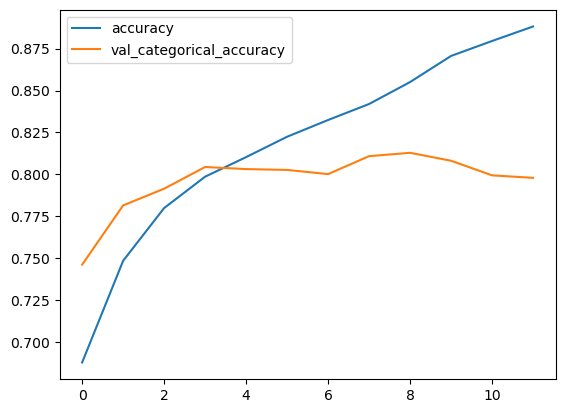

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
metrics = h.history
plt.plot(h.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()
plt.plot(h.epoch, metrics['categorical_accuracy'], metrics['val_categorical_accuracy'])
plt.legend(['accuracy', 'val_categorical_accuracy'])
plt.show()

In [ ]:
import json

# Load database
json_file = "C:/Users/guill/Downloads/xview_recognition/xview_recognition/xview_ann_test.json"
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [ ]:
import numpy as np

anns = []
for json_img, json_ann in zip(json_data['images'], json_data['annotations']):
    image = GenericImage("C:/Users/guill/Downloads/xview_recognition/xview_recognition/" + json_img['file_name'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.id = json_ann['id']
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = list(categories.values())[json_ann['category_id']-1]
    image.add_object(obj)
    anns.append(image)

In [ ]:
import numpy as np

# model.load_weights('model.hdf5', by_name=True)
y_true, y_pred = [], []
for ann in anns:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

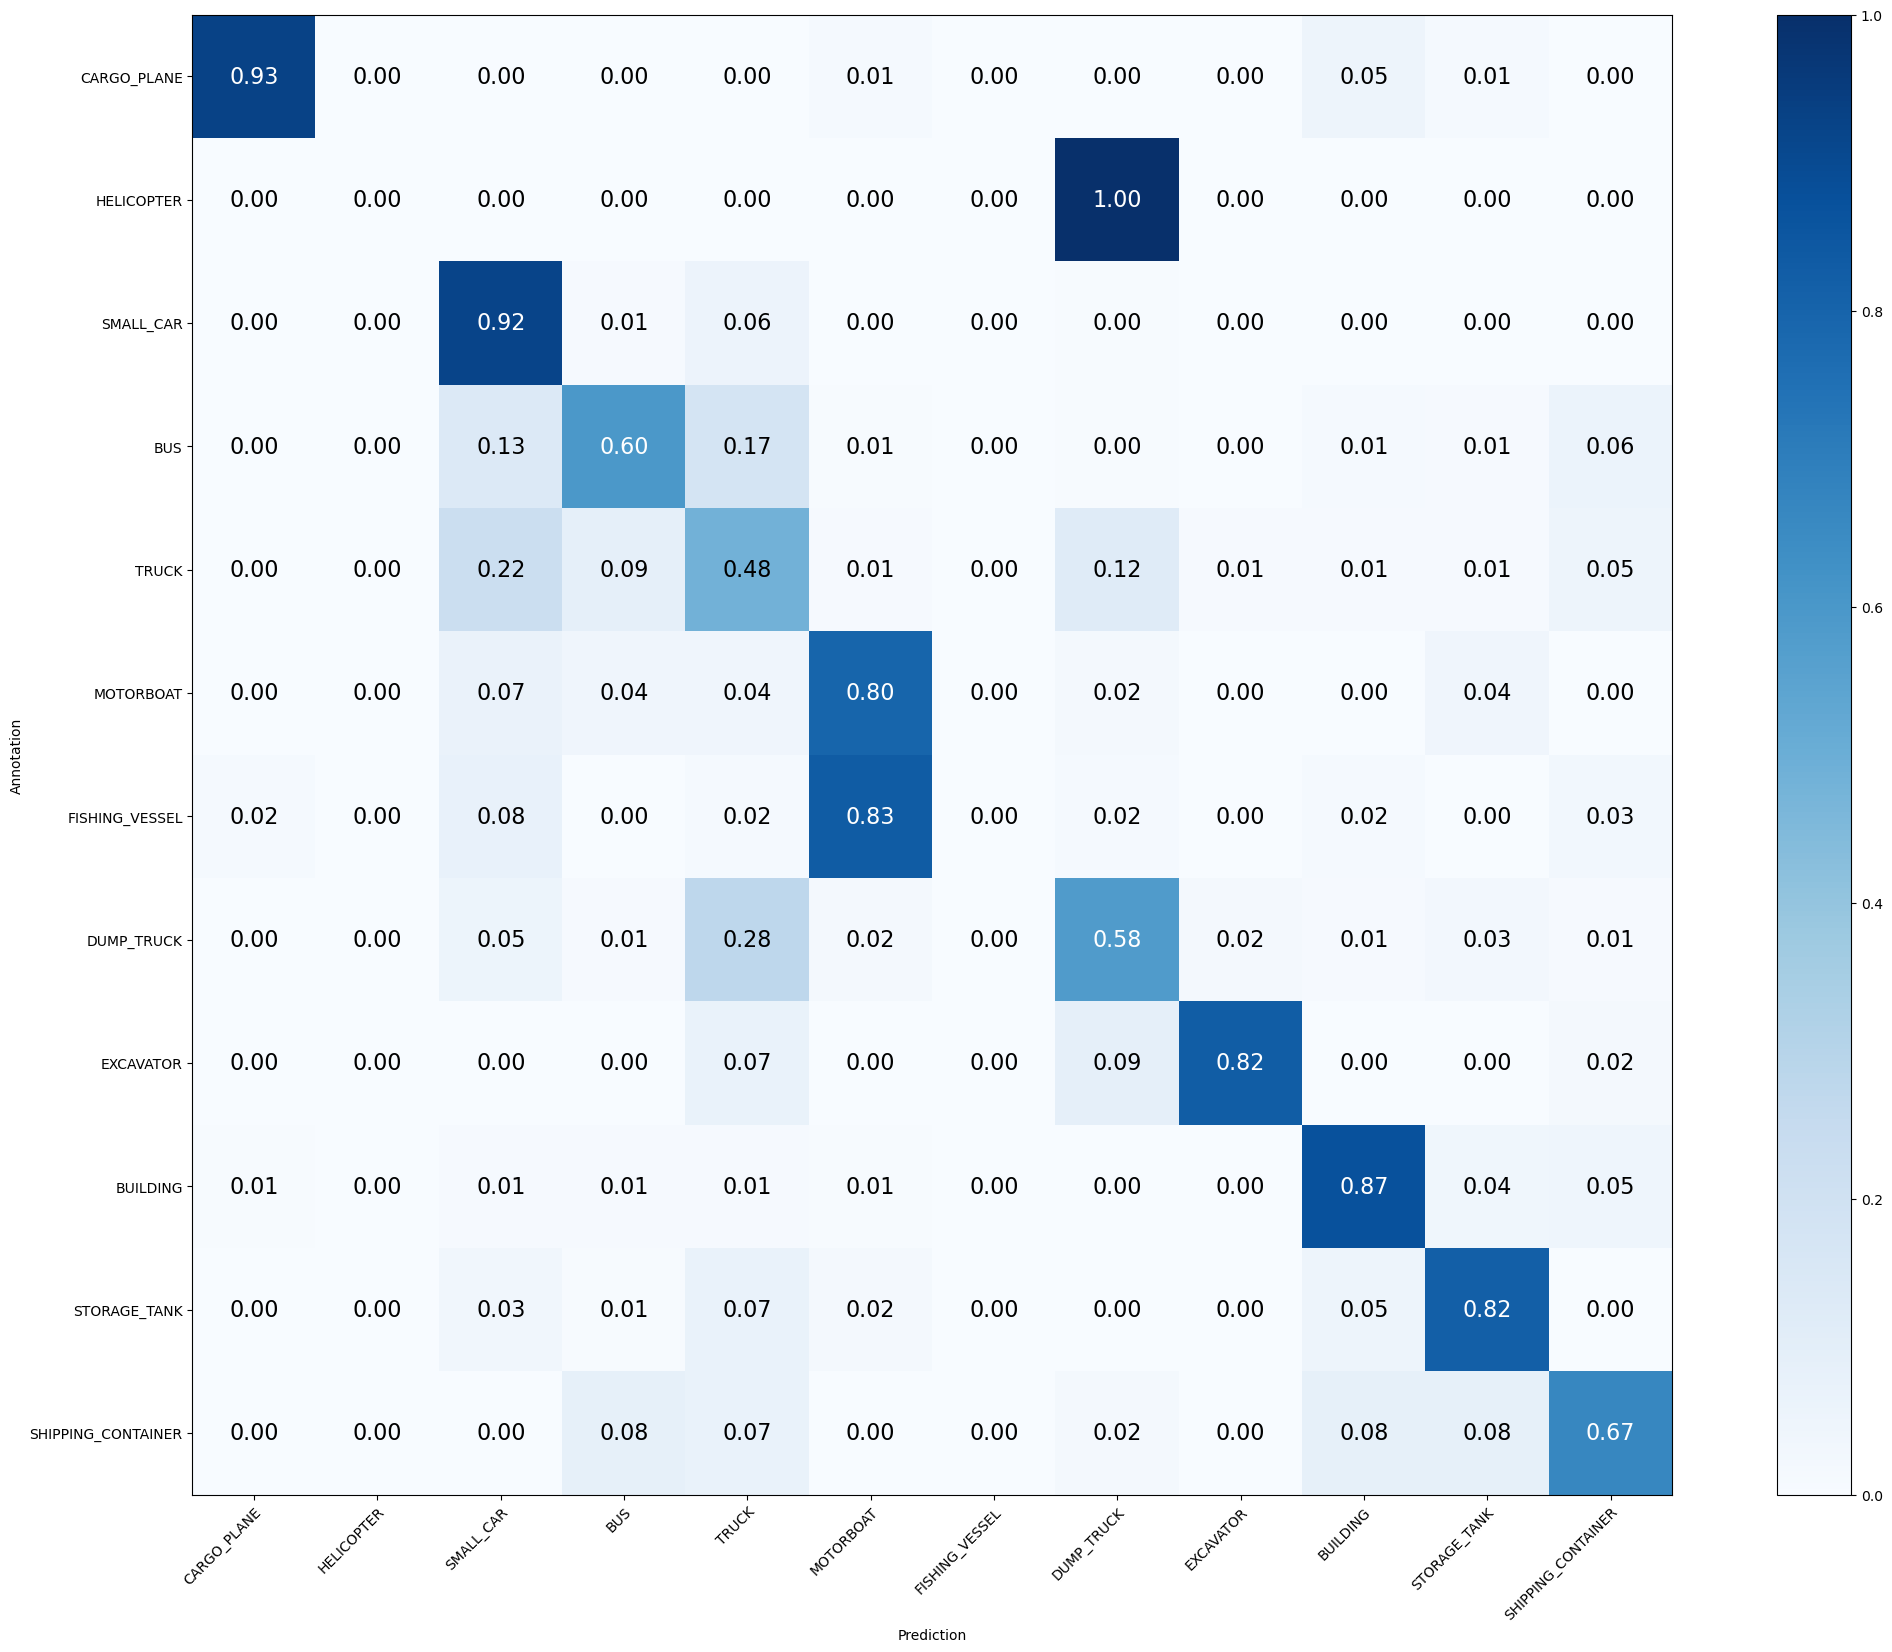

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [ ]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 77.894%
Mean Recall: 62.365%
Mean Precision: 54.311%
> CARGO_PLANE: Recall: 92.771% Precision: 86.517% Specificity: 99.744% Dice: 89.535%
> HELICOPTER: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> SMALL_CAR: Recall: 92.014% Precision: 83.914% Specificity: 92.388% Dice: 87.777%
> BUS: Recall: 59.513% Precision: 72.900% Specificity: 97.688% Dice: 65.530%
> TRUCK: Recall: 48.345% Precision: 59.469% Specificity: 94.390% Dice: 53.333%
> MOTORBOAT: Recall: 79.508% Precision: 53.297% Specificity: 98.174% Dice: 63.816%
> FISHING_VESSEL: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> DUMP_TRUCK: Recall: 58.036% Precision: 38.012% Specificity: 97.728% Dice: 45.936%
> EXCAVATOR: Recall: 82.456% Precision: 79.661% Specificity: 99.746% Dice: 81.034%
> BUILDING: Recall: 87.128% Precision: 97.609% Specificity: 98.979% Dice: 92.071%
> STORAGE_TANK: Recall: 81.944% Precision: 58.128% Specificity: 98.165% Dice: 68.012%
> SHIPPING_CONTAINER: 

#### Report

You must prepare a report (PDF) describing:
* The problems and data sets (briefly).
* The process that you have followed to reach your solution for the “xview_recognition” benchmark, including your intermediate results. You must discuss and compare these results properly.
* Final network architectures, including optimization algorithms, regularization methods (dropout, data augmentation, etc.), number of layers/parameters, and performance obtained with your model on the train/valid/test data sets, including the plots of the evolution of losses and accuracy.
* It would also be very valuable your feedback on the use of “Cesvima” or “Google Colab" services.

In the submission via Moodle, attach your Python (.py) or Jupyter Notebook (.ipynb) source file, including in the report all results of computations attached to the code that generated them.

The assignment must be done in groups of 3 students. Each team must submit one submission before Tuesday, April 18th, 2023, 23:55h.